In [4]:
import os
import requests
import tarfile
import torch
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import pickle

In [5]:
def download_cifar10(url, save_path):
    # Sending a GET request to the URL to start downloading the file
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    chunk_size = 1024
    with open(save_path, 'wb') as f:
        for data in response.iter_content(chunk_size=chunk_size):
            f.write(data)
            downloaded_size = os.path.getsize(save_path)
            progress = 100 * downloaded_size / total_size
            print('\rDownloading: {:.2f}%'.format(progress), end='', flush=True)
    print("\nDownload completed!")

# Download CIFAR-10 dataset
cifar10_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
save_path = "./cifar-10-python.tar.gz"
download_cifar10(cifar10_url, save_path)

Downloading: 100.00%
Download completed!


In [6]:
# Extracts the CIFAR-10 dataset from the tarball
def extract_cifar10(archive_path, extract_dir):
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(extract_dir)
    print("Extraction completed!")

archive_path = "./cifar-10-python.tar.gz"
extract_dir = "./cifar-10-python"
extract_cifar10(archive_path, extract_dir)

Extraction completed!


In [7]:
#converting the device to gpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [8]:
def load_cifar10(data_dir):
    images = []
    labels = []
    try:
        for file in os.listdir(data_dir):
            if file.startswith('data_batch') or file.startswith('test_batch'):
                with open(os.path.join(data_dir, file), 'rb') as fo:
                    cifar_data = pickle.load(fo, encoding='bytes')
                    for i, image_data in enumerate(cifar_data[b'data']):
                        # CIFAR-10 images are in CHW format (channels, height, width)
                        # Reshape the image to HWC format (height, width, channels)
                        image = np.transpose(np.reshape(image_data, (3, 32, 32)), (1, 2, 0))
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        label = cifar_data[b'labels'][i]
                        images.append(image)
                        labels.append(label)
    except Exception as e:
        print("Error loading CIFAR-10 dataset:", e)
    return np.array(images), np.array(labels)


# Function to preprocess images
def preprocess_images(images):
    # Resize images to a fixed size (e.g., 32x32)
    resized_images = [cv2.resize(image, (64, 64)) for image in images]
    processed_images = np.array(resized_images, dtype=np.float32) / 255.0
    return processed_images

data_dir = './cifar-10-python/cifar-10-batches-py'
images, labels = load_cifar10(data_dir)

processed_images = preprocess_images(images)

X_train, X_test, y_train, y_test = train_test_split(processed_images, labels, train_size=0.8, test_size=0.2, random_state=42)

n_classes = len(np.unique(y_train))

n_classes = len(np.unique(y_train))

print("Number of training samples:", len(X_train))
print("Number of test samples:", len(X_test))
print("Image shape:", X_train.shape)
print("Number of classes:", n_classes)

processed_images
labels

Number of training samples: 48000
Number of test samples: 12000
Image shape: (48000, 64, 64)
Number of classes: 10


array([1, 8, 5, ..., 1, 1, 5])

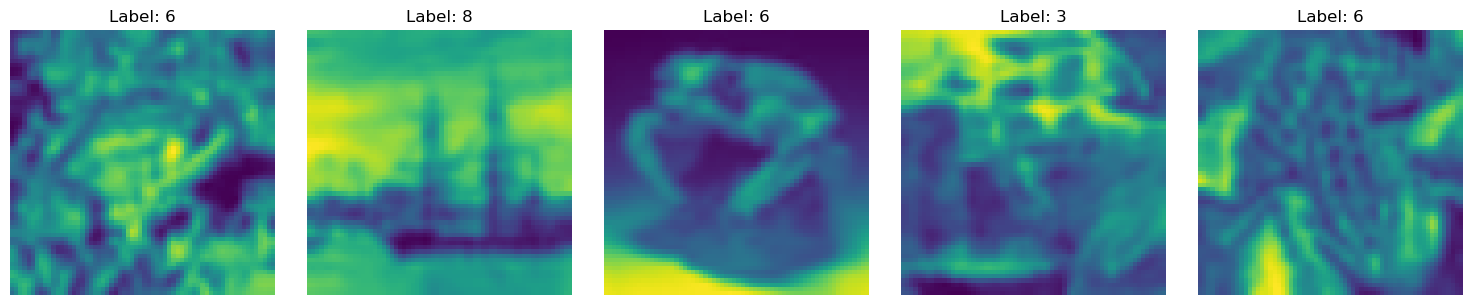

In [9]:
import matplotlib.pyplot as plt

def plot_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title("Label: {}".format(labels[i]))
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_images(X_train[:5], y_train[:5])


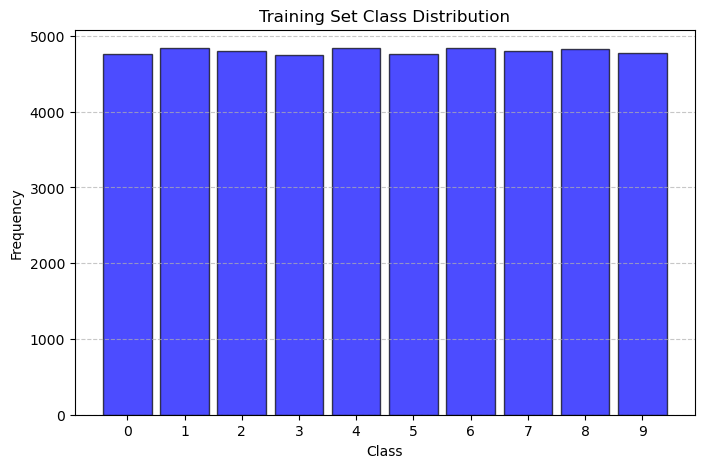

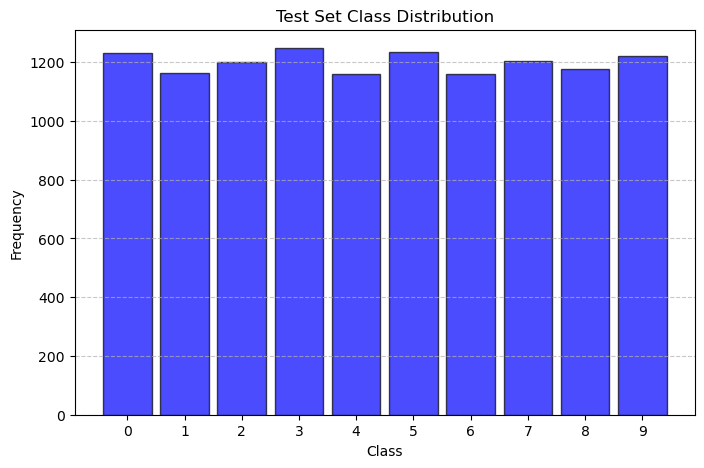

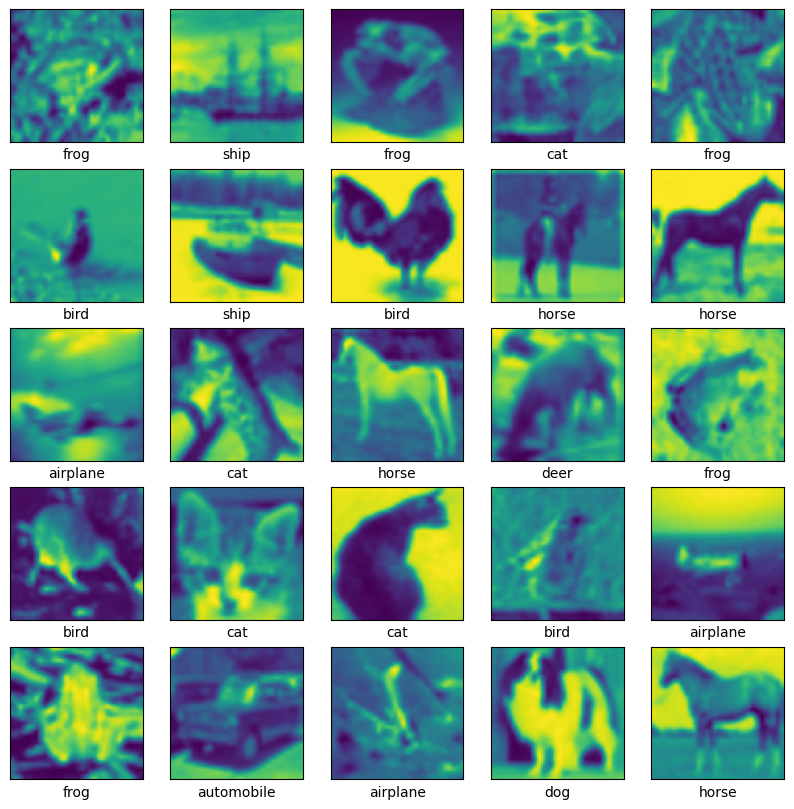

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to plot class distribution
def plot_class_distribution(labels, title):
    plt.figure(figsize=(8, 5))
    plt.hist(labels, bins=np.arange(11) - 0.5, alpha=0.7, rwidth=0.85, color='blue', edgecolor='black')
    plt.xticks(np.arange(10))
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Function to plot sample images
def plot_sample_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
    plt.show()

# Function to visualize data using PCA or t-SNE
def visualize_data(X, y, method='PCA', title=''):
    if method == 'PCA':
        reducer = PCA(n_components=2, random_state=42)
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Invalid method. Use 'PCA' or 't-SNE'.")

    X_reduced = reducer.fit_transform(X.reshape(X.shape[0], -1))
    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='tab10', alpha=0.7)
    plt.title(f'{method} Visualization - {title}')
    plt.colorbar()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 1. Plot class distribution
plot_class_distribution(y_train, 'Training Set Class Distribution')
plot_class_distribution(y_test, 'Test Set Class Distribution')

# 2. Plot sample images
plot_sample_images(X_train, y_train, class_names)



In [11]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

In [12]:
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)


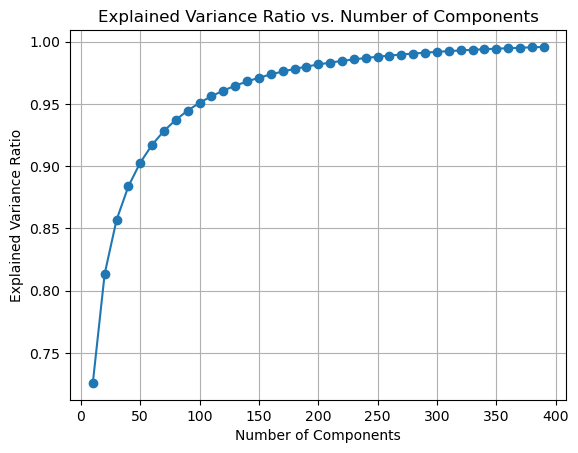

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_variance_ratio(pca):
    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance Ratio vs. Number of Components')
    plt.grid(True)
    plt.show()

# Fit PCA with various number of components
n_components_range = range(10, 400, 10)  # Example range, adjust as needed
explained_variance_ratios = []

for n_components in n_components_range:
    pca = PCA(n_components=n_components)
    pca.fit(X_train_flat)
    explained_variance_ratios.append(np.sum(pca.explained_variance_ratio_))

# Plot explained variance ratio
plt.plot(n_components_range, explained_variance_ratios, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()


In [14]:
pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


knn = KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train_pca, y_train)

y_pred_pca = knn.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy on PCA-transformed test data:", accuracy_pca)


Accuracy on PCA-transformed test data: 0.3234166666666667


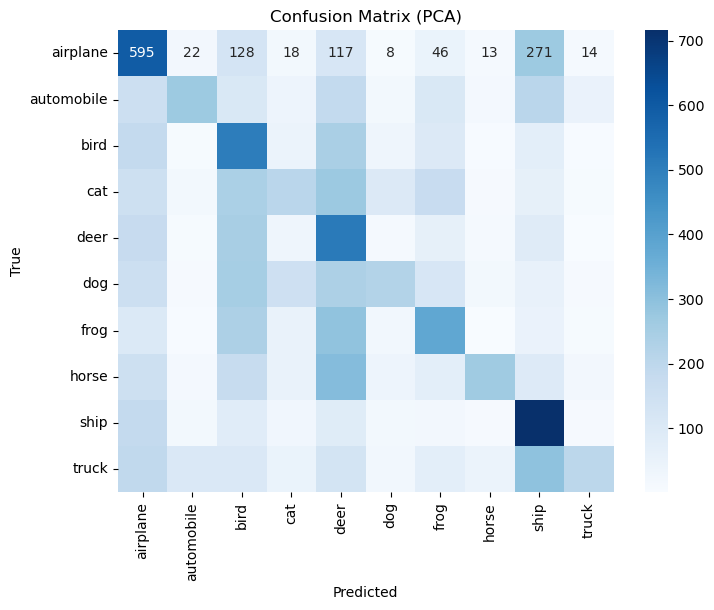

Classification Report:
              precision    recall  f1-score   support

    airplane       0.29      0.48      0.36      1232
  automobile       0.56      0.23      0.33      1164
        bird       0.24      0.42      0.31      1199
         cat       0.31      0.16      0.21      1248
        deer       0.21      0.44      0.29      1161
         dog       0.44      0.18      0.26      1234
        frog       0.33      0.33      0.33      1159
       horse       0.66      0.22      0.33      1204
        ship       0.37      0.61      0.46      1178
       truck       0.62      0.17      0.26      1221

    accuracy                           0.32     12000
   macro avg       0.40      0.33      0.31     12000
weighted avg       0.40      0.32      0.31     12000



In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_pca)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (PCA)')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_pca, target_names=class_names))


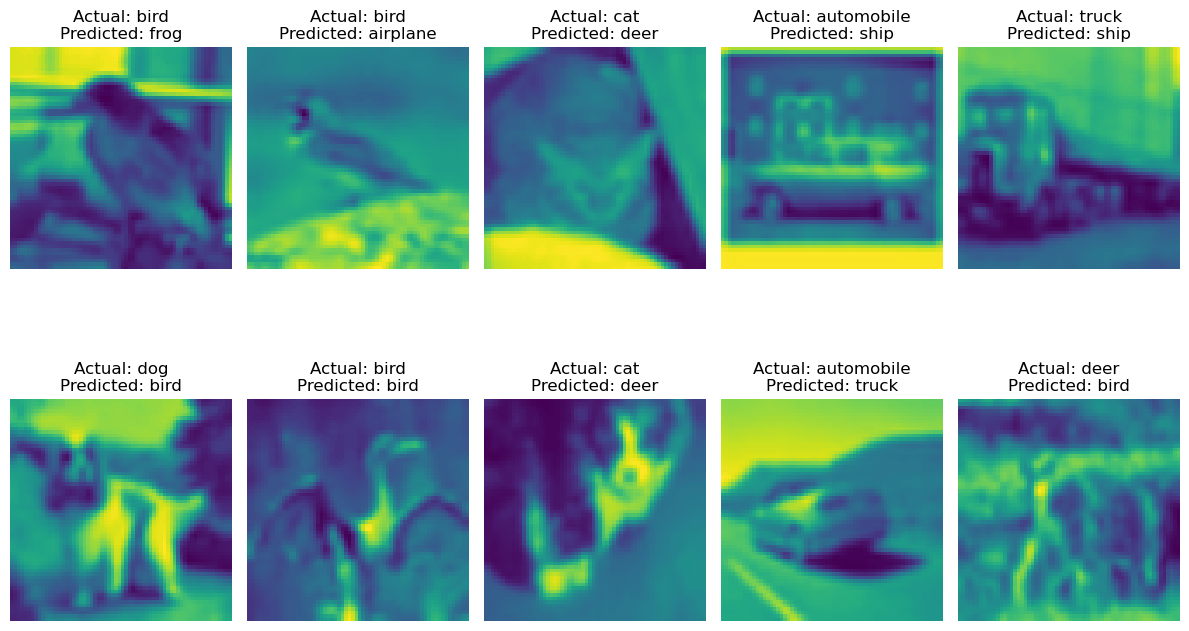

In [17]:
def plot_predicted_actual_images(images, actual_labels, predicted_labels, class_names, num_samples=10):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i+10])
        actual_label = class_names[actual_labels[i+10]]
        predicted_label = class_names[predicted_labels[i+10]]
        title = f'Actual: {actual_label}\nPredicted: {predicted_label}'
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot some sample images with predicted and actual labels
plot_predicted_actual_images(X_test, y_test, y_pred_pca, class_names)


In [18]:
lda = LinearDiscriminantAnalysis(n_components=n_classes-1)
X_train_lda = lda.fit_transform(X_train_flat, y_train)
X_test_lda = lda.transform(X_test_flat)

In [19]:
knn.fit(X_train_lda, y_train)

y_pred_lda = knn.predict(X_test_lda)

accuracy_lda = accuracy_score(y_test, y_pred_lda)
print("Accuracy on LDA-transformed test data:", accuracy_lda)



Accuracy on LDA-transformed test data: 0.21741666666666667


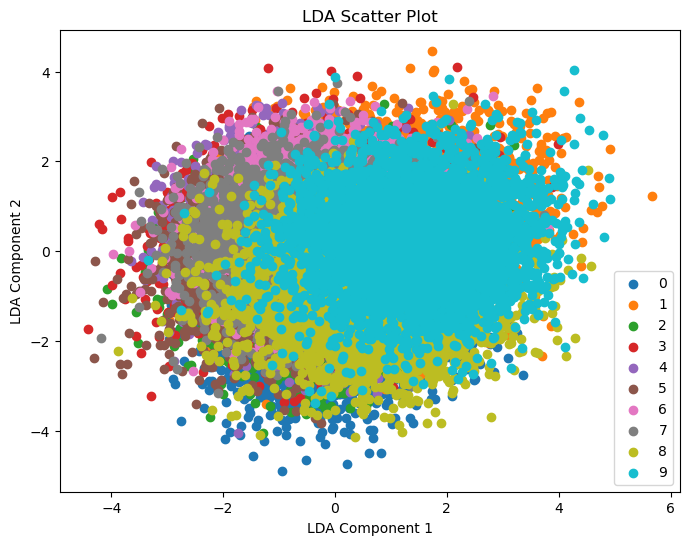

In [20]:
plt.figure(figsize=(8, 6))
for class_label in np.unique(y_train):
    plt.scatter(X_train_lda[y_train == class_label, 0], X_train_lda[y_train == class_label, 1], label=class_label)
plt.title('LDA Scatter Plot')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend()
plt.show()


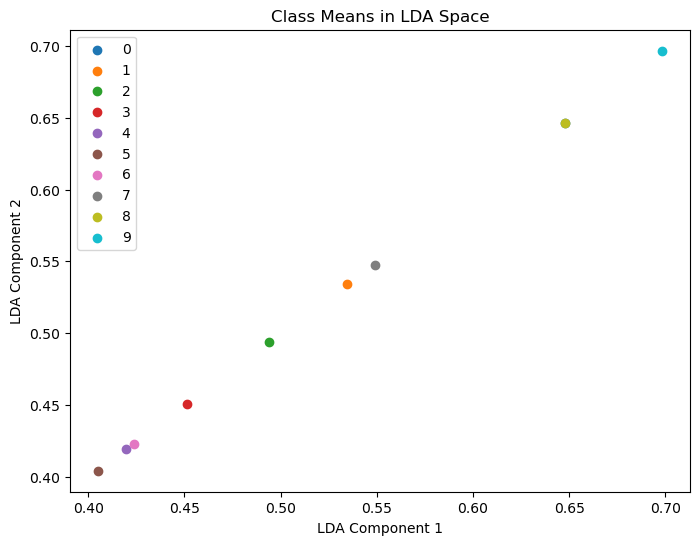

In [21]:
class_means = lda.means_
plt.figure(figsize=(8, 6))
for class_label in np.unique(y_train):
    plt.scatter(class_means[class_label, 0], class_means[class_label, 1], marker='o', label=class_label)
plt.title('Class Means in LDA Space')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend()
plt.show()


In [22]:
nb= GaussianNB()
nb.fit(X_train_flat, y_train)

GaussianNB()

In [23]:

nb_lda = GaussianNB()
nb_lda.fit(X_train_lda, y_train)


GaussianNB()

In [24]:
y_pred_nb = nb.predict(X_test_flat)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)

y_pred_nb_lda = nb_lda.predict(X_test_lda)
accuracy_nb_lda = accuracy_score(y_test, y_pred_nb_lda)
print("Naive Bayes for LDA Accuracy:", accuracy_nb_lda)

Naive Bayes Accuracy: 0.2653333333333333
Naive Bayes for LDA Accuracy: 0.23775


In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)
svm_clf = svm.SVC(kernel='rbf', gamma='scale', C=1.0)
svm_clf.fit(X_train_scaled, y_train)

SVC()

In [26]:
log_reg = LogisticRegression(max_iter=3000)
log_reg.fit(X_train_flat, y_train)

LogisticRegression(max_iter=3000)

In [28]:

# log_reg = LogisticRegression(max_iter=1000)
# log_reg.fit(X_train_flat, y_train)

random_forest = RandomForestClassifier(n_estimators=200, random_state=42)
random_forest.fit(X_train_flat, y_train)

decision_tree = DecisionTreeClassifier(max_depth = 20, random_state=42)
decision_tree.fit(X_train_flat, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


knn = KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train_pca, y_train)

y_pred_pca = knn.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy on PCA-transformed test data:", accuracy_pca)


knn.fit(X_train_lda, y_train)

y_pred_lda = knn.predict(X_test_lda)

accuracy_lda = accuracy_score(y_test, y_pred_lda)
print("Accuracy on LDA-transformed test data:", accuracy_lda)


y_pred_nb = nb.predict(X_test_flat)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)

y_pred_nb_lda = nb_lda.predict(X_test_lda)
accuracy_nb_lda = accuracy_score(y_test, y_pred_nb_lda)
print("Naive Bayes for LDA Accuracy:", accuracy_nb_lda)

y_pred = svm_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)

Accuracy on PCA-transformed test data: 0.3234166666666667
Accuracy on LDA-transformed test data: 0.21741666666666667
Naive Bayes Accuracy: 0.2653333333333333
Naive Bayes for LDA Accuracy: 0.23775
SVM Accuracy: 0.47058333333333335


In [30]:
y_pred = log_reg.predict(X_test_flat)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

y_pred_rf = random_forest.predict(X_test_flat)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

y_pred_dt = decision_tree.predict(X_test_flat)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy_dt)


AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [31]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.flatten = nn.Flatten()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

model = SimpleClassifier(num_inputs=4096, num_hidden=1000, num_outputs=10)
model.to(device)

BATCH_SIZE = 128

train_dataset = data.TensorDataset(torch.tensor(X_train_flat, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
train_data_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)

X_train_pca_tensor = torch.tensor(X_train_pca)
y_train_tensor = torch.tensor(y_train)

train_dataset_pca = data.TensorDataset(X_train_pca_tensor, y_train_tensor)
train_dataloader_pca = DataLoader(train_dataset_pca, batch_size=BATCH_SIZE, shuffle=True)

loss_fn = nn.CrossEntropyLoss()

# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.026)

def accuracy_fn(y_true, y_pred):
 
    correct = (y_true == y_pred).sum()

    # Calculate the accuracy
    accuracy = correct / len(y_true)

    return accuracy

# def train_model(model, optimizer, data_loader, loss_fn, num_epochs=100):
#     # Set model to train mode
#     model.to(device)
#     model.train()
#     train_loss, train_acc = 0, 0

#     # Training loop
#     for epoch in tqdm(range(num_epochs)):
#         for data_inputs, data_labels in data_loader:

#             ## Step 1: Move input data to device (only strictly necessary if we use GPU)
#             data_inputs = data_inputs.to(device)
#             data_inputs = data_inputs.to(torch.float32)
#             data_labels = data_labels.to(device).to(torch.int64)
            
            
#             ## Step 2: Run the model on the input data
#             preds = model(data_inputs)
#             y = data_labels
#             loss = loss_fn(preds, y)
#             train_loss += loss
#             train_acc += accuracy_fn(y_true=y,y_pred=preds.argmax(dim=1))


#             ## Step 3: Perform backpropagation
#             # Before calculating the gradients, we need to ensure that they are all zero.
#             # The gradients would not be overwritten, but actually added to the existing ones.
#             optimizer.zero_grad()
#             # Perform backpropagation
#             loss.backward()

#             ## Step 4: Update the parameters
#             optimizer.step()
    
#     train_loss /= len(data_loader)
#     train_acc /= len(data_loader)

# train_model(model, optimizer, train_data_loader, loss_fn)
def train_model(model, optimizer, data_loader, loss_fn, num_epochs=100):
    model.to(device)
    model.train()
    
    # Lists to store loss and accuracy for each epoch
    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0
        epoch_correct = 0
        epoch_samples = 0
        
        for data_inputs, data_labels in data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            loss = loss_fn(preds, data_labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * data_inputs.size(0)
            epoch_correct += (preds.argmax(1) == data_labels).sum().item()
            epoch_samples += data_inputs.size(0)
        
        epoch_losses.append(epoch_loss / epoch_samples)
        epoch_accuracies.append(epoch_correct / epoch_samples)
    
    return epoch_losses, epoch_accuracies

test_dataset = data.TensorDataset(torch.tensor(X_test_flat, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

X_test_pca_tensor = torch.tensor(X_test_pca)
y_test_tensor = torch.tensor(y_test)

test_dataset_pca = data.TensorDataset(X_test_pca_tensor, y_test_tensor)
test_dataloader_pca = DataLoader(test_dataset_pca, batch_size=BATCH_SIZE, shuffle=False)

# def eval_model(model, data_loader):
#     model.eval() # Set model to eval mode
#     true_preds, num_preds = 0., 0.
#     test_loss, test_acc = 0, 0

#     with torch.no_grad(): # Deactivate gradients for the following code
#         for data_inputs, data_labels in data_loader:

#             # Determine prediction of model on dev set
#             data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
#             y = data_labels
#             data_inputs = data_inputs.to(torch.float32)
#             preds = model(data_inputs)
#             preds = preds.squeeze(dim=1)
#             preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
#             test_loss += loss_fn(preds, y)
    
#             test_acc += accuracy_fn(y_true=y,y_pred=preds.argmax(dim=1))

#     test_loss /= len(data_loader)
#     test_acc /= len(data_loader)
#     print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%\n") 
    

# eval_model(model, test_data_loader)
def eval_model(model, data_loader):
    model.eval()
    test_loss = 0
    test_correct = 0
    test_samples = 0
    
    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            loss = loss_fn(preds, data_labels)
            
            test_loss += loss.item() * data_inputs.size(0)
            test_correct += (preds.argmax(1) == data_labels).sum().item()
            test_samples += data_inputs.size(0)
    
    return test_loss / test_samples, test_correct / test_samples


  0%|          | 0/10 [00:00<?, ?it/s]

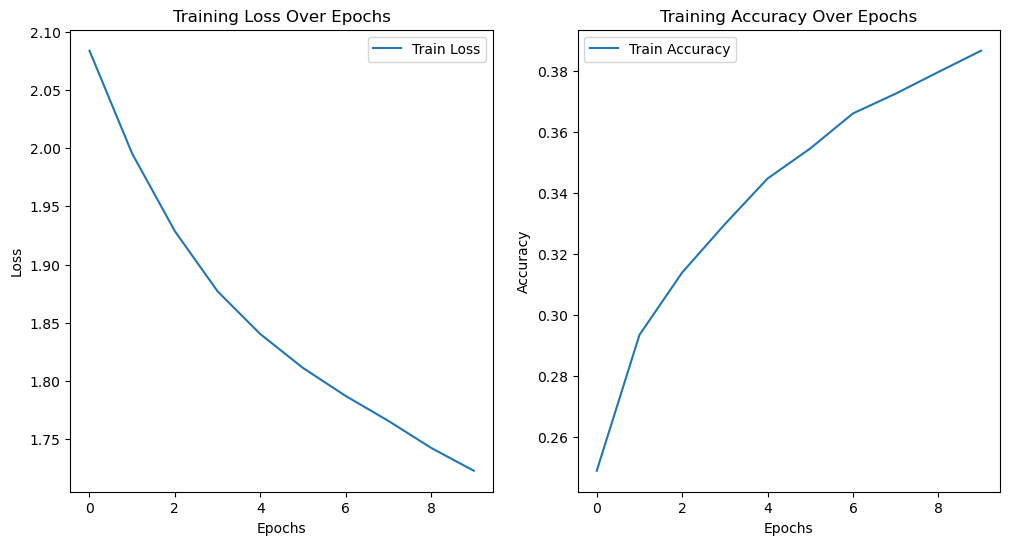

Final Test Loss: 1.73344
Final Test Accuracy: 38.03%


In [32]:
import matplotlib.pyplot as plt

# Assuming model training and validation happens here
train_losses, train_accuracies = train_model(model, optimizer, train_data_loader, loss_fn, num_epochs=10)
test_loss, test_accuracy = eval_model(model, test_data_loader)

# Plotting training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Printing test results
print(f"Final Test Loss: {test_loss:.5f}")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


In [33]:
import torch

# Assuming 'model' is your PyTorch model
torch.save(model.state_dict(), 'model.pth')

In [47]:
import cv2
import numpy as np
import torch
from torchvision import transforms

# Define a function to preprocess the user-provided image
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    # Resize the image to 64x64
    resized_image = cv2.resize(image, (64, 64))
    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    # Convert the image to float32 and normalize
    normalized_image = grayscale_image.astype(np.float32) / 255.0
    # Convert the image to tensor and add batch dimension
    tensor_image = torch.tensor(normalized_image).unsqueeze(0).unsqueeze(0)
    return tensor_image

# Load the model
model = SimpleClassifier(num_inputs=4096, num_hidden=1000, num_outputs=10)
model.load_state_dict(torch.load('model.pth'))  # Load your trained model weights here
model.eval()

# Function to predict label for user-provided image
def predict_image_label(image_path, model):
    # Preprocess the image
    input_tensor = preprocess_image(image_path)
    # Forward pass through the model
    with torch.no_grad():
        output = model(input_tensor)
    # Get the predicted label
    predicted_label = torch.argmax(output).item()
    return predicted_label

# User-provided image path
user_image_path = '/home/anwesh2410/Sem 4/PRML/Proj/seee/doggie.jpeg'

# Predict label for user-provided image
predicted_label = predict_image_label(user_image_path, model)
print("Predicted label for the image:", predicted_label)

Predicted label for the image: 5


In [ ]:
class ObjectRecognition(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, hidden_units1: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_units, out_features=hidden_units1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_units1, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = x.to(torch.float32)
        return self.layer_stack(x)

    
model_1 = ObjectRecognition(input_shape=150, hidden_units=256,hidden_units1=128, output_shape=10)
model_1.to(device)
 

model_2 = ObjectRecognition(input_shape=4096, hidden_units=1024,hidden_units1=512, output_shape=10)
model_2.to(device)



In [ ]:
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.10)
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001) 

In [ ]:
epochs = 1
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_model(model=model_1,optimizer=optimizer_1,data_loader=train_dataloader_pca,loss_fn=loss_fn)
    
    eval_model(model=model_1,data_loader=test_dataloader_pca)


In [ ]:
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_model(model=model_2,optimizer=optimizer_2,data_loader=train_data_loader,loss_fn=loss_fn)
    
    eval_model(model=model_2,data_loader=test_data_loader)